#### Load LLM

In [1]:
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

#### Ground truth data from Sea Dataset

In [2]:
sea_ice_variables = [
    "geopotential_heights", 
    "relative_humidity", 
    "sea_level_pressure",  
    "zonal_wind_at_10_meters", 
    "meridional_wind_at_10_meters", 
    "sensible_plus_latent_heat_flux", 
    "total_precipitation", 
    "total_cloud_cover", 
    "total_cloud_water_path",  
    "surface_net_shortwave_flux", 
    "surface_net_longwave_flux", 
    "northern_hemisphere_sea_ice_extent",
]

treatment = "surface_net_longwave_flux"
outcome = "northern_hemisphere_sea_ice_extent"

# ground truth confounders to the relationship between surface_net_longwave_flux and northern_hemisphere_sea_ice_extent
ground_truth_confounders = ["total_precipitation"]
   
ground_truth_graph = {
    ("surface_net_longwave_flux", "northern_hemisphere_sea_ice_extent"), 
    
    ("geopotential_heights", "surface_net_longwave_flux"), 
    ("geopotential_heights", "relative_humidity"), 
    ("geopotential_heights", "sea_level_pressure"), 

    ("relative_humidity", "total_cloud_cover"), 
    ("relative_humidity", "total_cloud_water_path"),
    ("relative_humidity", "total_precipitation"), 
    ("relative_humidity", "surface_net_longwave_flux"),

    ("sea_level_pressure", "relative_humidity"), 
    ("sea_level_pressure", "geopotential_heights"), 
    ("sea_level_pressure", "zonal_wind_at_10_meters"), 
    ("sea_level_pressure", "northern_hemisphere_sea_ice_extent"), 
    ("sea_level_pressure", "sensible_plus_latent_heat_flux"), 
    ("sea_level_pressure", "meridional_wind_at_10_meters"),

    ("zonal_wind_at_10_meters", "northern_hemisphere_sea_ice_extent"),
    ("zonal_wind_at_10_meters", "sensible_plus_latent_heat_flux"), 
    
    ("meridional_wind_at_10_meters", "northern_hemisphere_sea_ice_extent"),
    ("meridional_wind_at_10_meters", "sensible_plus_latent_heat_flux"), 
   
    ("sensible_plus_latent_heat_flux", "northern_hemisphere_sea_ice_extent"), 
    ("sensible_plus_latent_heat_flux", "sea_level_pressure"), 
    ("sensible_plus_latent_heat_flux", "zonal_wind_at_10_meters"), 
    ("sensible_plus_latent_heat_flux", "meridional_wind_at_10_meters"), 
    ("sensible_plus_latent_heat_flux", "total_precipitation"), 
    ("sensible_plus_latent_heat_flux", "total_cloud_cover"), 
    ("sensible_plus_latent_heat_flux", "total_cloud_water_path"), 
    
    ("total_precipitation", "northern_hemisphere_sea_ice_extent"),
    ("total_precipitation", "relative_humidity"),
    ("total_precipitation", "sensible_plus_latent_heat_flux"),
    ("total_precipitation", "surface_net_longwave_flux"),
    ("total_precipitation", "total_cloud_cover"),
    ("total_precipitation", "total_cloud_water_path"),
   
    ("total_cloud_water_path", "total_precipitation"), 
    ("total_cloud_water_path", "sensible_plus_latent_heat_flux"), 
    ("total_cloud_water_path", "relative_humidity"), 
    ("total_cloud_water_path", "surface_net_longwave_flux"), 
    ("total_cloud_water_path", "surface_net_shortwave_flux"), 
    
    ("total_cloud_cover", "total_precipitation"),
    ("total_cloud_cover", "sensible_plus_latent_heat_flux"),
    ("total_cloud_cover", "relative_humidity"),
    ("total_cloud_cover", "surface_net_longwave_flux"),
    ("total_cloud_cover", "surface_net_shortwave_flux"), 
    
    ("surface_net_shortwave_flux", "northern_hemisphere_sea_ice_extent"),
    
    ("northern_hemisphere_sea_ice_extent", "sea_level_pressure"),
    ("northern_hemisphere_sea_ice_extent", "zonal_wind_at_10_meters"),
    ("northern_hemisphere_sea_ice_extent", "meridional_wind_at_10_meters"),
    ("northern_hemisphere_sea_ice_extent", "sensible_plus_latent_heat_flux"),
    ("northern_hemisphere_sea_ice_extent", "surface_net_shortwave_flux"),
    ("northern_hemisphere_sea_ice_extent", "surface_net_longwave_flux"),
    }

#### Select random dataset subset

In [3]:
import random 

random.seed(42)  # Set the random seed for reproducibility
subset_size = 7
selected_variables = random.sample(sea_ice_variables[:-2], subset_size)

selected_variables.append(treatment)
selected_variables.append(outcome)  


print(selected_variables)

# grab the relationships that match the subset variables
subset_graph = set()    
for a in selected_variables:
    for b in selected_variables:
        if a != b and (a, b) in ground_truth_graph:
            subset_graph.add((a, b))



['relative_humidity', 'geopotential_heights', 'meridional_wind_at_10_meters', 'surface_net_shortwave_flux', 'total_precipitation', 'sensible_plus_latent_heat_flux', 'total_cloud_water_path', 'surface_net_longwave_flux', 'northern_hemisphere_sea_ice_extent']


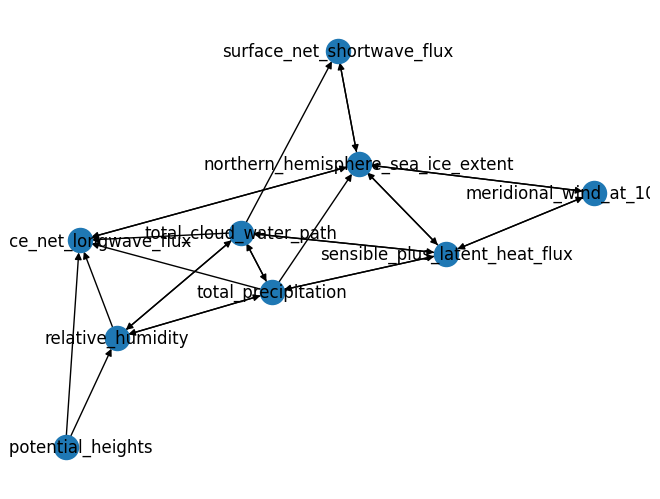

In [4]:
import networkx as nx

g = nx.DiGraph()
g.add_nodes_from(selected_variables)
g.add_edges_from(subset_graph)

'''show graph'''
import matplotlib.pyplot as plt

nx.draw(g, with_labels=True)
plt.show()

#### Generate Synthetic Dataset

In [5]:
import pandas as pd
import dowhy.datasets

synthetic_data = dowhy.datasets.linear_dataset(
    beta=1,
    treatment_is_binary=False,
    num_common_causes=len(selected_variables),
    num_samples=5000
)

df = synthetic_data['df']
print(df.head())

ate = synthetic_data['ate']
print("ATE:", ate)

c:\Users\t-rdesicilia\Documents\VSCodeProjects\Augment\askwhy_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         W0        W1        W2        W3        W4        W5        W6  \
0  2.246212 -1.765715 -0.459702  0.459773 -0.779446  0.646419 -0.156080   
1  0.269901  0.702776 -0.812901 -1.083297 -0.888273  1.119750 -0.137983   
2 -0.544189  1.677751 -0.999273  1.082264 -1.825352  1.120703  1.109224   
3  0.594696  0.663954 -0.901641 -0.308464 -0.471983  0.291064  2.662688   
4  2.518876  0.502186 -0.152934 -0.445098  0.297198  0.388883 -0.534310   

         W7        W8        v0         y  
0 -1.448428 -0.755482 -1.668289 -3.860941  
1 -0.002573 -1.148893  1.325411 -0.066006  
2  0.209563 -0.825764  0.371269  1.710107  
3  0.116390 -0.953752  0.646597  1.122578  
4 -0.353098  0.360248  1.581228  1.736702  
ATE: 1.0000221465184074


# Modeler

#### Create Modeler

In [6]:
from model_suggester import ModelSuggester
modeler = ModelSuggester()

#### Suggest Confounders

In [7]:
suggested_confounders = modeler.suggest_confounders(variables=selected_variables, llm=gpt4, treatment=treatment, outcome=outcome)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user Is it true that changing total_cloud_water_path can change surface_net_longwave_flux and northern_hemisphere_sea_ice_extent ? 
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Provide your final answer within the tags, <answer>A/B</answer>. assistant The total cloud water path refers to the amount of liquid water in clouds in a column of the atmosphere. Changes in this can indeed affect the surface net longwave flux, as clouds play a significant role in the Earth's energy balance. They can absorb, reflect, and emit radiation, thus affecting the longwave (infrared) radiation that reaches the surface.

As for the northern hemisphere sea ice extent, it is influenced by a variety of factors, including atmospheric and oceanic temperatures, wind patterns, and ocean currents. While changes in the total cloud water path can affect the Earth's energy balance and thus potentially influence these factors, the relationship is indirect and complex.

So, the answer is:

<answer>A. Yes</answer>

However, it's important to note that while changing total cloud water path can affect these variables, it's not the sole determinant of them. Other factors also play significant roles.

['A. Yes']


In [8]:
suggested_confounders

['relative_humidity',
 'geopotential_heights',
 'surface_net_shortwave_flux',
 'total_precipitation',
 'sensible_plus_latent_heat_flux',
 'total_cloud_water_path']

#### Suggest Pairwise Relationships

In [9]:
relationships = modeler.suggest_relationships(variables=selected_variables, llm=gpt4)

TypeError: ModelSuggester.suggest_relationships() got an unexpected keyword argument 'variables_and_descriptions'

In [ ]:
relationships

In [ ]:
[('relative_humidity', 'surface_net_shortwave_flux'),
 ('relative_humidity', 'sensible_plus_latent_heat_flux'),
 ('relative_humidity', 'total_cloud_water_path'),
 ('relative_humidity', 'surface_net_longwave_flux'),
 ('relative_humidity', 'northern_hemisphere_sea_ice_extent'),
 ('geopotential_heights', 'relative_humidity'),
 ('geopotential_heights', 'meridional_wind_at_10_meters'),
 ('geopotential_heights', 'total_precipitation'),
 ('geopotential_heights', 'sensible_plus_latent_heat_flux'),
 ('geopotential_heights', 'total_cloud_water_path'),
 ('meridional_wind_at_10_meters', 'relative_humidity'),
 ('meridional_wind_at_10_meters', 'surface_net_shortwave_flux'),
 ('meridional_wind_at_10_meters', 'total_precipitation'),
 ('meridional_wind_at_10_meters', 'sensible_plus_latent_heat_flux'),
 ('meridional_wind_at_10_meters', 'total_cloud_water_path'),
 ('meridional_wind_at_10_meters', 'surface_net_longwave_flux'),
 ('meridional_wind_at_10_meters', 'northern_hemisphere_sea_ice_extent'),
 ('surface_net_shortwave_flux', 'geopotential_heights'),
 ('surface_net_shortwave_flux', 'total_precipitation'),
 ('surface_net_shortwave_flux', 'sensible_plus_latent_heat_flux'),
 ('surface_net_shortwave_flux', 'total_cloud_water_path'),
 ('surface_net_shortwave_flux', 'surface_net_longwave_flux'),
 ('surface_net_shortwave_flux', 'northern_hemisphere_sea_ice_extent'),
 ('total_precipitation', 'relative_humidity'),
 ('total_precipitation', 'sensible_plus_latent_heat_flux'),
 ('total_precipitation', 'surface_net_longwave_flux'),
 ('total_precipitation', 'northern_hemisphere_sea_ice_extent'),
 ('sensible_plus_latent_heat_flux', 'total_cloud_water_path'),
 ('sensible_plus_latent_heat_flux', 'northern_hemisphere_sea_ice_extent'),
 ('total_cloud_water_path', 'total_precipitation'),
 ('total_cloud_water_path', 'surface_net_longwave_flux'),
 ('total_cloud_water_path', 'northern_hemisphere_sea_ice_extent'),
 ('surface_net_longwave_flux', 'geopotential_heights'),
 ('surface_net_longwave_flux', 'sensible_plus_latent_heat_flux'),
 ('surface_net_longwave_flux', 'northern_hemisphere_sea_ice_extent'),
 ('northern_hemisphere_sea_ice_extent', 'geopotential_heights')]

#### Full Graph

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

g = nx.DiGraph()
g.add_nodes_from(selected_variables)
g.add_edges_from(relationships)

nx.draw(g, with_labels=True)
plt.show()


# Identifier

In [ ]:
from identification_suggestor import IdentificationSuggestor 
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

# set the default language model used to execute guidance programs
gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

#### Create Identifier

In [ ]:
identifier = IdentificationSuggestor()

#### Suggest Backdoor

In [ ]:
backdoor = identifier.suggest_backdoor(llm=gpt4, treatment=treatment, outcome=outcome, variables=selected_variables)
print("Backdoor\n", backdoor)

#### Suggest Frontdoor

In [ ]:
frontdoor = identifier.suggest_frontdoor(llm=gpt4, treatment=treatment, outcome=outcome, variables=selected_variables)
print("Frontdoor\n", frontdoor) 

#### Suggest IVs

In [ ]:
iv = identifier.suggest_iv(llm=gpt4, treatment=treatment, outcome=outcome, variables=selected_variables)
print("Instrumental Variable\n", iv) 

#### Suggest Estimand


In [5]:
estimand = identifier.suggest_estimand(llm=gpt4, variables=selected_variables, treatment=treatment, outcome=outcome, backdoor=backdoor, frontdoor=frontdoor, iv=iv)  

NameError: name 'identifier' is not defined

In [ ]:
estimand

# Validator

In [1]:
from validation_suggestor import ValidationSuggestor 
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

# set the default language model used to execute guidance programs
gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

In [2]:
validator = ValidationSuggestor()

In [3]:
relationships = [('relative_humidity', 'surface_net_shortwave_flux'),
 ('relative_humidity', 'sensible_plus_latent_heat_flux'),
 ('relative_humidity', 'total_cloud_water_path'),
 ('relative_humidity', 'surface_net_longwave_flux'),
 ('relative_humidity', 'northern_hemisphere_sea_ice_extent'),
 ('geopotential_heights', 'relative_humidity'),
 ('geopotential_heights', 'meridional_wind_at_10_meters'),
 ('geopotential_heights', 'total_precipitation'),
 ('geopotential_heights', 'sensible_plus_latent_heat_flux'),
 ('geopotential_heights', 'total_cloud_water_path'),
 ('meridional_wind_at_10_meters', 'relative_humidity'),
 ('meridional_wind_at_10_meters', 'surface_net_shortwave_flux'),
 ('meridional_wind_at_10_meters', 'total_precipitation'),
 ('meridional_wind_at_10_meters', 'sensible_plus_latent_heat_flux'),
 ('meridional_wind_at_10_meters', 'total_cloud_water_path'),
 ('meridional_wind_at_10_meters', 'surface_net_longwave_flux'),
 ('meridional_wind_at_10_meters', 'northern_hemisphere_sea_ice_extent'),
 ('surface_net_shortwave_flux', 'geopotential_heights'),
 ('surface_net_shortwave_flux', 'total_precipitation'),
 ('surface_net_shortwave_flux', 'sensible_plus_latent_heat_flux'),
 ('surface_net_shortwave_flux', 'total_cloud_water_path'),
 ('surface_net_shortwave_flux', 'surface_net_longwave_flux'),
 ('surface_net_shortwave_flux', 'northern_hemisphere_sea_ice_extent'),
 ('total_precipitation', 'relative_humidity'),
 ('total_precipitation', 'sensible_plus_latent_heat_flux'),
 ('total_precipitation', 'surface_net_longwave_flux'),
 ('total_precipitation', 'northern_hemisphere_sea_ice_extent'),
 ('sensible_plus_latent_heat_flux', 'total_cloud_water_path'),
 ('sensible_plus_latent_heat_flux', 'northern_hemisphere_sea_ice_extent'),
 ('total_cloud_water_path', 'total_precipitation'),
 ('total_cloud_water_path', 'surface_net_longwave_flux'),
 ('total_cloud_water_path', 'northern_hemisphere_sea_ice_extent'),
 ('surface_net_longwave_flux', 'geopotential_heights'),
 ('surface_net_longwave_flux', 'sensible_plus_latent_heat_flux'),
 ('surface_net_longwave_flux', 'northern_hemisphere_sea_ice_extent'),
 ('northern_hemisphere_sea_ice_extent', 'geopotential_heights')]

In [4]:
critiqued_edges = validator.critique_graph(edges=relationships, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to factually and concisely answer questions about cause and effect relationships using your domain knowledge on artic sea ice and atmosphere sciences. user Analyze the output from an AI assistant. Is the final answer A consistent with the reasoning provided by the assistant?
 
 Question
 Which cause and effect relationship is more likely?
 A. sensible_plus_latent_heat_flux causes geopotential_heights ?
 B. geopotential_heights causes sensible_plus_latent_heat_flux ?
 C. Neither. No causal relationship exists. 
 Let's think step-by-step to make sure that we have the right answer. Keep your argument to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B/C</answer>.
 
 AI Assistant Explanation
 Geopotential height is a measure of the potential energy of a unit mass relative to sea level, and it is influenced by the temperature of the atmospheric column. Sensible and latent heat fluxes, on the other hand, are measures of heat transfer from the Earth's surface to the atmosphere. Thus, it is more likely that sensible and latent heat fluxes, which can change the temperature of the atmosphere, would have an effect on geopotential heights, rather than the other way around. However, it's important to note that these relationships are complex and can be influenced by a variety of other factors. 
 
 Critique the AI Assistant's argument by providing your own individual version of the argument. Provide your explanations within the tags, <explanation>...</explanation> and answer your final answer to the question within the tags, <answer>A/B/C</answer>. assistant <explanation>The AI assistant's reasoning is correct. Geopotential height is a measure of the potential energy of a unit mass relative to sea level, and it is affected by the temperature of the atmospheric column. Sensible and latent heat fluxes represent the heat transfer from the Earth's surface to the atmosphere. Therefore, it is more plausible that sensible and latent heat fluxes, which can alter the atmospheric temperature, would influence geopotential heights rather than the reverse. It's crucial to remember, though, that these relationships are intricate and can be affected by numerous other factors.</explanation>

<answer>B</answer>